In [90]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image
from scipy.ndimage import *


In [91]:
def get_Sobel_filter():
    """
    get two sobel filter as required
    """
    Ax = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]])
    Ay = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])
    return Ax , Ay

def convolution(img, filter):
    """
    write convolution between image and sobel filter
    """

    # prepare filter for convolution
    filter = np.flip(filter, 0)
    filter = np.flip(filter, 1)

    filter_size = filter.shape[0]
    h,w = img.shape

    # expand the image by padding size
    padding = filter_size // 2
    expand_img = np.zeros((h + padding * 2, w + padding * 2))
    # leave the padding entry be 0, the center be the original image
    expand_img[padding:-padding, padding:-padding] = img
    

    # do convolution
    result = np.zeros(img.shape)
    for i in range(h):
        for j in range(w):
            result[i,j]= (filter * expand_img[i:i+filter_size, j:j+filter_size]).sum()
    
    return result

In [187]:
def getGradient(img, thres):
    """
    get the magnitude of the derivatives
    """
    gradient = np.zeros(img.shape)
    direction = np.zeros(img.shape)

    # filter_x, filter_y = get_Sobel_filter()
    # grad_x = convolution(img, filter_x)
    # grad_y = convolution(img, filter_y)

    # grad_x, grad_y = np.gradient(img)

    grad_x = cv2.Sobel(img, cv2.CV_64F,1,0,ksize = 5)
    grad_y = cv2.Sobel(img, cv2.CV_64F,0,1,ksize = 5)

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            gradient[x][y] = (grad_x[x][y] ** 2 + grad_y[x][y] ** 2) ** 0.5
            if gradient[x][y] < thres:
                gradient[x][y] = 0
            if grad_x[x][y] == 0:
                direction[x][y] = 90
            else:
                direction[x][y] = math.atan(grad_y[x][y] / grad_x[x][y]) * 180 / math.pi
            if direction[x][y] < -15:
                direction[x][y] += 180
    return gradient, direction



In [188]:
def set_cellgrid(img, tao):
    m, n = img.shape[0] // tao, img.shape[1] // tao
    return m, n

def HOG(img, thres, tao):
    m, n = set_cellgrid(img, tao)
    gradient, direction = getGradient(img, thres)

    magnitude_hist = np.zeros((m,n,6))
    occur_hist = np.zeros((m,n,6))

    bins = [(-15, 15), (15,45), (45, 75), (75, 105), (105, 135), (135,165)]

    for i_index in range(m*tao):
        for j_index in range(n*tao):
            i = i_index // tao
            j = j_index // tao
            if -15 <= direction[i_index][j_index] and direction[i_index][j_index] < 15:
                magnitude_hist[i][j][0] += gradient[i_index][j_index]
                occur_hist[i][j][0] += 1
            elif 15 <= direction[i_index][j_index] and direction[i_index][j_index] < 45:
                magnitude_hist[i][j][1] += gradient[i_index][j_index]
                occur_hist[i][j][1] += 1
            elif 45 <= direction[i_index][j_index] and direction[i_index][j_index] < 75:
                magnitude_hist[i][j][2] += gradient[i_index][j_index]
                occur_hist[i][j][2] += 1
            elif 75 <= direction[i_index][j_index] and direction[i_index][j_index] < 105:
                magnitude_hist[i][j][3] += gradient[i_index][j_index]
                occur_hist[i][j][3] += 1
            elif 105 <= direction[i_index][j_index] and direction[i_index][j_index] < 135:
                magnitude_hist[i][j][4] += gradient[i_index][j_index]
                occur_hist[i][j][4] += 1
            elif 135 <= direction[i_index][j_index] and direction[i_index][j_index] < 165:
                magnitude_hist[i][j][5] += gradient[i_index][j_index]
                occur_hist[i][j][5] += 1

    return magnitude_hist, occur_hist


In [189]:
def plot_hist(img, choice, tao):
    m,n = set_cellgrid(img, tao)

    img = img.astype('float') / 255.0
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)

    x_grid = np.r_[int(tao / 2) : tao * n -1: tao]
    y_grid = np.r_[int(tao /2) : tao * m -  1: tao]

    meshX, meshY = np.meshgrid(x_grid, y_grid)
    for i in range(6):
        plt.quiver(meshX, meshY, np.sin(i * np.pi/6)*choice[:,:,i], np.cos(i * np.pi/6)*choice[:,:,i],  pivot='middle',color="red")
    plt.show()

In [190]:
def Normalize(img, tao, file_path, hist, e = 0.001):
    m,n = set_cellgrid(img, tao)
    descriptor = np.zeros((m-1,n-1,24))
    for i in range(m-1):
        for j in range(n-1):
            sum_h = 0
            for k in range(6):
                sum_h += hist[i][j][k] ** 2 + hist[i+1][j][k] ** 2+ hist[i][j+1][k] ** 2 + hist[i+1][j+1][k] ** 2
                descriptor[i][j][k] = hist[i][j][k]
                descriptor[i][j][k+6] = hist[i+1][j][k]
                descriptor[i][j][k+12] = hist[i][j+1][k]
                descriptor[i][j][k+18] = hist[i+1][j+1][k]
            for k in range(24):
                descriptor[i][j][k] = descriptor[i][j][k] / math.sqrt(sum_h + e*e)
    write_txt(file_path, descriptor)
    return descriptor

def write_txt(file_path, descriptor):
    f = open(file_path, "w")
    m,n,p = descriptor.shape
    for i in range(m):
        for j in range(n):
            for k in range(p):
                f.write(str(descriptor[i][j][k]) + "  ")
            f.write("\n")
    f.close()
            


In [233]:
def transfer_Norm(hist):
    m, n= hist.shape[0]+1, hist.shape[1]+1
    hist1 = hist[:,:,:6]
    hist2 = hist[:,:,6:12]
    hist3 = hist[:,:,12:18]
    hist4 = hist[:,:,18:24]

    result = np.zeros((m,n,6))

    result[1:m-1, 1:n-1, :] = hist1[1:, 1:,:] + hist2[:m-2, 1:, :] + hist3[1:, :n-2,:] + hist4[:m-2, :n-2,:]
    result[0,0,:], result[0,n-1,:], result[m-1,0,:], result[m-1,n-1,:] = hist1[0,0,:], hist2[0,n-2,:], hist3[m-2,0,:], hist4[m-2,n-2,:]
    result[0,1:n-1, :] = (hist1[0, 1:,:] + hist2[0,:n-2,:])/2
    result[m-1,1:n-1, :] = (hist3[m-2, 1:,:] + hist4[m-2,:n-2,:])/2
    result[1:m-1,0, :] = (hist1[1:, 0,:] + hist3[:m-2,0,:])/2
    result[1:m-1,n-1,:] = (hist2[1:, n-2,:] + hist4[:m-2,n-2,:])/2

    return result
    
    

In [235]:
def plot_description(img, choice, tao):
    m,n = set_cellgrid(img, tao)

    img = img.astype('float') / 255.0
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)

    x_grid = np.r_[int(tao / 2) : tao * n -1: tao]
    y_grid = np.r_[int(tao / 2) : tao * m -1: tao]

    meshX, meshY = np.meshgrid(x_grid, y_grid)
    for i in range(6):
        print(choice.shape)
        sum_choice = transfer_Norm(choice)
        print(sum_choice.shape)
        plt.quiver(meshX, meshY, np.sin(i * np.pi/6)*sum_choice, np.cos(i * np.pi/6)*sum_choice,  pivot='middle',color="red")
    plt.show()

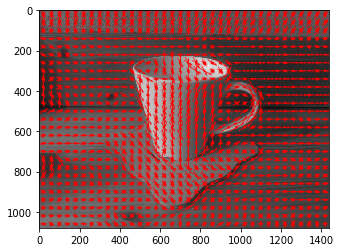

(26, 35, 24)


ValueError: too many values to unpack (expected 2)

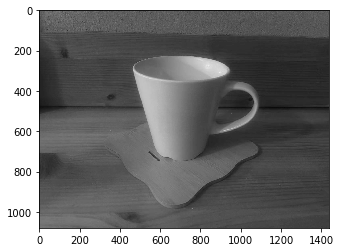

In [234]:
threshold = 10
tao = 40
file_path = "4.txt"

img = cv2.imread("Q3/4.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

magnitude_hist, occur_hist = HOG(img, threshold, tao)

choice = occur_hist

plot_hist(img, choice, tao)
desciption = Normalize(img, tao, file_path, choice)
plot_description(img, desciption, tao)